#PyTorch Intro - Trenowanie i Ewaluacja Sieci Neuronowej - Lab


#Zadanie

Zaadaptuj kod z notatnika *PyTorch Intro - Trenowanie i Ewaluacja Sieci Neuronowej - Wykład* do problemu klasyfikacji liczby gwiazdek dla opinii z serwisu Yelp.


* Wykorzystaj zbiór `Yelp/yelp_review_full` ([link](https://huggingface.co/datasets/Yelp/yelp_review_full)) zawierający opinie z serwisu Yelp (kolumna: `text`) i etykietę (kolumna: `label`) o wartościach $0,1,2,3,4$ określającą liczbę gwiazdek przyznaną przez użytkownika (a ściślej, liczbę gwiazdek minus jeden).
    * Zgodnie z dobrą praktyką z części treningowej wydziel dodatkową część walidacyjną.
    * Ogranicz rozmiar każdej części zbioru danych (treningowej, walidacyjnej i testowej). Część treningowa nie powinna zawierać więcej niż 100k elementów.
* Do ekstrakcji cech z tekstu wykorzystaj **metodę TF-IDF** (*term frequency-inverse document frequency*) opartą o podejście typu worek słów (*bag-of-words*). Zastosuj funkcję `TfidfVectorizer` z biblioteki `scikit-learn`.
* Wykorzystaj podobną architekturę sieci (perceptron wielowarstwowy z warstwą Dropout) jak w notatniku wykładowym.



## Punkty do wykonania

1.   
Napisz funkcję znajdującą i wyświetlającą $k$ elementów zbioru testowego dla których model najbardziej się myli, czyli estymuje najmniejsze prawdopodobieństwa prawdziwej klasy. Softmax jest funkcją ściśle rosnącą, więc wystarczy znaleźć elementy z najmniejszą wartością nieznormalizowanego wyjścia z sieci (logita) dla prawdziwej klasy.
2.   Zbadaj wpływ wybranych parametrów funkcji ekstrakcji cech z tekstu `TfidfVectorizer` na skuteczność wytrenowanego modelu. Uruchom kilka eksperymentów z różnymi wartościami parametrów i porównaj dokładność wytrenowanego modelu na zbiorze walidacyjnym.
3.   Zbadaj wpływ wybranych hiperparametrów modelu (np. liczba warstw liniowych modelu, rozmiary warstw) i procesu uczenia (np. początkowa wartość stopy uczenia, liczba epok, typ i parametry planisty stopy uczenia, typ i parametry optymalizatora) na skuteczność wytrenowanego modelu. Uruchom kilka eksperymentów z różnymi wartościami hiperparametrów i porównaj dokładność wytrenowanego modelu na zbiorze walidacyjnym. Następnie wykonaj finalną ewaluację najlepszego modelu na zbiorze testowym.


##Przygotowanie środowiska
Upewnij się, że notatnik jest uruchomiony na maszynie z GPU. Jesli GPU nie jest dostępne zmień typ maszyny (Runtime | Change runtime type) i wybierz T4 GPU.

In [1]:
!nvidia-smi

Thu Mar 20 11:36:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 571.96                 Driver Version: 571.96         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8              5W /   65W |       1MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Instalacja dodatkowych bibliotek: datasets (z biblioteki HuggingFace), TorchMetrics i W&B (Weights and Biases) Models.

In [2]:
!pip install -q datasets
!pip install -q torchmetrics



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import bibliotek.

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

print(f"Wersja biblioteki PyTorch: {torch.__version__}")

Wersja biblioteki PyTorch: 2.6.0+cu126


Sprawdzenie dostępności GPU.

In [4]:
print(f"Dostępność GPU: {torch.cuda.is_available()}")
print(f"Typ GPU: {torch.cuda.get_device_name(0)}")

Dostępność GPU: True
Typ GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [5]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("Yelp/yelp_review_full")
print(dataset)

test_dataset = dataset["test"]

# Wydziel część walidacyjną ze zbioru treningowego
split_dataset = dataset["train"].train_test_split(test_size=0.2)  # 80% train, 20% validation
train_dataset = split_dataset["train"]
val_dataset = split_dataset["test"]

# Utwórz mniejsze podzbiory treningowe, walidacyjne i testowe
train_dataset = train_dataset.shuffle().select(range(int(len(train_dataset) * .15)))
val_dataset = val_dataset.shuffle().select(range(int(len(val_dataset) * .1)))
test_dataset = test_dataset.shuffle().select(range(int(len(test_dataset) * .4)))

print(f"Liczba próbek w zbiorze treningowym: {len(train_dataset)}")
print(f"Liczba próbek w zbiorze walidacyjnym: {len(val_dataset)}")
print(f"Liczba próbek w zbiorze testowym: {len(test_dataset)}")

C:\Users\mateu\Documents\GitHub\Python-Toolkit-Playground\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\mateu\Documents\GitHub\Python-Toolkit-Playground\.venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mateu\.cache\huggingface\hub\datasets--Yelp--yelp_review_full. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})
Liczba próbek w zbiorze treningowym: 78000
Liczba próbek w zbiorze walidacyjnym: 13000
Liczba próbek w zbiorze testowym: 20000


In [6]:
sample = train_dataset[123]
print(f"\nPrzykładowy element ze zbioru danych:")
print(f"{sample['text']=}")
print(f"{sample['label']=}")


Przykładowy element ze zbioru danych:
sample['text']='Watch out for the upsell at this \\"joint\\".  Also they will tack on a junk \\"service charge\\" fee of $20 for \\"toner, paper and floor mats\\" - thats the manager\'s quote.\\nWill not use a business that quotes a price for service, then adds a junk fee.  Was called either a \\"shop charge\\" or \\"service charge\\".\\nIt\'s an insult to customers.'
sample['label']=0


# Rozwiązanie

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tqdm import tqdm

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_features(vocab_size, lowercase=True, analyzer='word', ngram_range=(1, 1), stop_words="english"):
  vectorizer = TfidfVectorizer(
    max_features=vocab_size,    # Ogranicz do max_features najczęściej występujących słów
    lowercase=lowercase,             # Przekształć na małe litery
    analyzer=analyzer,            # Analiza na poziomie słów (a nie pojedynczych znaków)
    ngram_range=ngram_range,         # Unigramy (pojedynczne słowa)
    stop_words=stop_words        # Usuń częste słowa w języku angielskim (np. a, the, and)
  )

  # Ekstrakcja cech
  # Na zbiorze treningowym stosujemy funkcję fit_transform() która wyznacza cech i dokonuje ich ekstrakcji
  train_tfidf_features = vectorizer.fit_transform(train_dataset["text"])
  # Na zbiorze walidacyjnym i testowym stosujemy funkcję transform() które dokonuje ekstrakcji tych samych cech co na zbiorze treningowym
  val_tfidf_features = vectorizer.transform(val_dataset["text"])
  test_tfidf_features = vectorizer.transform(test_dataset["text"])
  feature_names = vectorizer.get_feature_names_out()

  return train_tfidf_features, val_tfidf_features, test_tfidf_features, feature_names

In [9]:
vocab_size = 10000
train_tfidf_features, val_tfidf_features, test_tfidf_features, feature_names = get_tfidf_features(vocab_size)

In [10]:
print(f"Rozmiar macierzy TF-IDF dla zbioru treningowego: {train_tfidf_features.shape}")
print(f"{train_tfidf_features.dtype=}\n")

print(f"Liczba cech: {len(feature_names)}")
print(f"Przykładowe cechy: {np.random.choice(feature_names, 20)}\n")

Rozmiar macierzy TF-IDF dla zbioru treningowego: (78000, 10000)
train_tfidf_features.dtype=dtype('float64')

Liczba cech: 10000
Przykładowe cechy: ['rye' 'marys' 'sleep' 'nhaving' 'chip' 'pipes' 'rates' 'towners' 'munch'
 'dread' 'nthey' 'decadent' 'nwaiter' 'mecca' 'george' 'ken' 'icy' 'board'
 'djs' 'alterations']



In [11]:
ndx = 111
print(f"Element zbioru treningowego o indeksie={ndx}")
print(f"{train_dataset['text'][ndx]=}\n")
features = train_tfidf_features[ndx]
print(f"Cechy elementu o indeksie={ndx}:")
non_zero_cols = features.nonzero()[1]

non_zero_cols = sorted(non_zero_cols)
for i in non_zero_cols:
    print(f"Kolumna: {i} ({feature_names[i]})   Waga: {features[0, i]:.5f}")

Element zbioru treningowego o indeksie=111
train_dataset['text'][ndx]="I just got back from AZ Hair Company. While I used to frequent the location in Chandler as a teenager, it was my first time at this particular location. Initially, I was really iffy, because I've heard that other locations were not nearly as good, but I really needed a haircut and I needed it at a reasonable price. I had my hair cut for about $20, including gratuity. I had my hair done by Christine and she was a total sweetheart. I'm more than happy with how my hair came out."

Cechy elementu o indeksie=111:
Kolumna: 52 (20)   Waga: 0.10736
Kolumna: 723 (az)   Waga: 0.15817
Kolumna: 1382 (came)   Waga: 0.08051
Kolumna: 1570 (chandler)   Waga: 0.17961
Kolumna: 1904 (company)   Waga: 0.13385
Kolumna: 2301 (cut)   Waga: 0.12516
Kolumna: 3575 (frequent)   Waga: 0.16259
Kolumna: 3787 (good)   Waga: 0.05283
Kolumna: 3801 (got)   Waga: 0.07413
Kolumna: 3842 (gratuity)   Waga: 0.18971
Kolumna: 3951 (hair)   Waga: 0.55774
Ko

Średnia liczba niezerowych cech w próbkach: 47.97


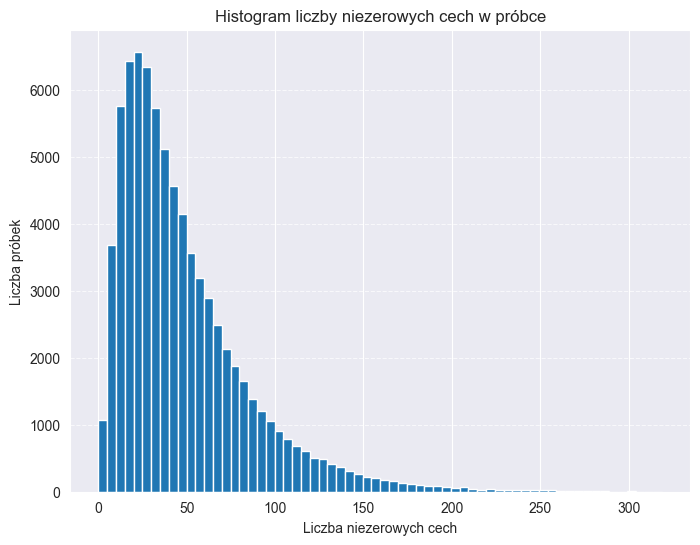

In [12]:
# train_tfidf_features jest rzadką macierzą w formacie CSR (compressed sparse row matrix)
# Poniższy trik pozwala szybko wyznaczyć liczbę niezerowych elementów w każdym wierszu
# .indptr jest N+1 elementową tablicą taką, że indptr[i+1]-indptr[i] jest liczbą niezerowych wartości w i-tym wierszu
# Patrz: https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr

non_zero_counts = np.diff(train_tfidf_features.indptr)
print(f"Średnia liczba niezerowych cech w próbkach: {non_zero_counts.mean():.2f}")

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(non_zero_counts, bins=64)
plt.title('Histogram liczby niezerowych cech w próbce')
plt.xlabel('Liczba niezerowych cech')
plt.ylabel('Liczba próbek')
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [13]:
import torch

from torch.utils.data import TensorDataset, DataLoader

In [14]:
def make_dataset(sparse_features, labels):
    # Zamień rzadką macierz cech na zwykłą (gęstą) macierz ndarray
    dense_features = sparse_features.astype(np.float32).todense()
    # Utwórz zbiór danych na podstawie tensora z cechami i tensora z etykietami
    dataset = TensorDataset(
        torch.from_numpy(dense_features),
        torch.tensor(labels, dtype=torch.int64)
    )
    return dataset

In [15]:
# Utwórz trzy zbiory danych: treningowy, walidacyjny i testowy
datasets = {
    'train': make_dataset(train_tfidf_features, train_dataset['label']),
    'val': make_dataset(val_tfidf_features, val_dataset['label']),
    'test': make_dataset(test_tfidf_features, test_dataset['label'])
}

# Wyświetl przykładowy element
print(datasets['train'][0])

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), tensor(3))


In [16]:
batch_size = 256

dataloaders = {split: DataLoader(datasets[split], batch_size=batch_size, shuffle=split=='train', num_workers=0) for split in datasets}

In [17]:
for X_batch, y_batch in dataloaders['train']:
    print(f"{X_batch.shape=}")
    print(f"{y_batch.shape=}")
    break

X_batch.shape=torch.Size([256, 10000])
y_batch.shape=torch.Size([256])


In [18]:
import torch.nn as nn

class ReviewScoreClassifier(nn.Module):
    def __init__(self, vocab_size: int, n_classes: int):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_classes = n_classes

        self.feature_extractor = nn.Sequential(
            nn.Linear(self.vocab_size, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(16, n_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(x)
        features = self.dropout(features)
        logits = self.linear(features)
        return logits

In [19]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Urządzenie: {}".format(device))

Urządzenie: cuda:0


In [20]:
# Utwórz model sieci neuronowej i prześlij na właściwe urządzenie
classifier = ReviewScoreClassifier(vocab_size, n_classes=5)
classifier.to(device)

print(classifier)

ReviewScoreClassifier(
  (feature_extractor): Sequential(
    (0): Linear(in_features=10000, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=16, out_features=5, bias=True)
)


In [21]:
# Utworzenie 5-elementowego wsadu tensorów o vocab_size elementach każdy
x = torch.rand((5, vocab_size))
print(x)
print(f"{x.shape=}\n")

x = x.to(device)        # Przenieś tensor na GPU

logits = classifier(x)
print(f"{logits=}")
print(f"{logits.shape=}\n")

probabilities = nn.functional.softmax(logits, dim=-1)
print(f"{probabilities=}")

tensor([[0.3175, 0.6658, 0.7417,  ..., 0.8100, 0.3683, 0.9097],
        [0.7604, 0.0263, 0.2377,  ..., 0.3449, 0.8074, 0.7146],
        [0.7398, 0.2680, 0.3592,  ..., 0.6998, 0.1072, 0.9091],
        [0.9022, 0.3647, 0.3575,  ..., 0.9697, 0.7896, 0.3973],
        [0.5310, 0.7897, 0.4502,  ..., 0.3046, 0.5097, 0.1109]])
x.shape=torch.Size([5, 10000])

logits=tensor([[-0.1248, -0.2060, -0.1183,  0.0629, -0.0499],
        [-0.1157, -0.1348, -0.1151,  0.0568,  0.0203],
        [-0.1873, -0.2228, -0.1742,  0.1066, -0.0446],
        [-0.1343, -0.2132, -0.1259,  0.0882, -0.0236],
        [-0.1431, -0.2043, -0.1444,  0.0771, -0.0172]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
logits.shape=torch.Size([5, 5])

probabilities=tensor([[0.1918, 0.1769, 0.1931, 0.2314, 0.2068],
        [0.1881, 0.1846, 0.1882, 0.2235, 0.2155],
        [0.1827, 0.1763, 0.1851, 0.2451, 0.2107],
        [0.1887, 0.1744, 0.1903, 0.2357, 0.2108],
        [0.1880, 0.1768, 0.1877, 0.2343, 0.2132]], device='cuda:0',

In [22]:
import torchmetrics


def train(model: nn.Module, loaders: dict[DataLoader], criterion: nn.Module,
          optimizer: torch.optim.Optimizer, lr_scheduler, num_epochs: int, verbose=1):

    # Metryki wyznaczane dla wsadu
    metric_loss = torchmetrics.aggregation.MeanMetric().to(device)
    metric_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=5).to(device)

    # Run all epochs
    for epoch in range(1, num_epochs+1):

        for phase in ['train', 'val']:
            # WAŻNE - przełącz model w odpowiedni tryb
            if phase == 'train':
                model.train()  # Przełącz model w tryb treningowy
            else:
                model.eval()   # Przełącz model w tryb ewaluacyjny

            # Loop over each batch in the data loader
            for X_batch, target in tqdm(loaders[phase], disable=not verbose):
                # Przenieś dane na odpowiednie urządzenie
                X_batch, target = X_batch.to(device), target.to(device)

                # Wyzeruj gradienty parametrów sieci
                # BARDZO WAŻNY KROK - domyślnie gradienty nie są zerowane i akumulują się dla wielu kroków przejścia w tył
                optimizer.zero_grad()

                # Przejście w przód (forward)
                # Śledzenie historii obliczeń tylko w fazie trenowania
                with torch.set_grad_enabled(phase == 'train'):
                    logits = model(X_batch)
                    _, preds = torch.max(logits, dim=1)
                    loss = criterion(logits, target)

                    # Zaktualizuj wartości metryk
                    metric_loss(loss)
                    metric_acc(preds, target)

                    # Przejście w tył (backward) i krok optymalizacji parametrów sieci tylko w fazie trenowania
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

            # Wyznacz średnie wartości metryk dla wsad
            acc = metric_acc.compute()
            mean_loss = metric_loss.compute()
            current_lr = lr_scheduler.get_last_lr()[0]
            if verbose:
              print(f"(Epoch {epoch}/[{phase}]) Loss:\t{mean_loss:.3f}   Accuracy: {acc:.3f}   lr: {current_lr}")
            metrics = {
                f"{phase}/loss": mean_loss,
                f"{phase}/accuracy": acc,
                f"{phase}/lr": current_lr,
            }

            # Wyzeruj metryki
            metric_loss.reset()
            metric_acc.reset()
            # KONIEC JEDNEJ FAZY W EPOCE (TRENING LUB WALIDACJA)

        lr_scheduler.step()
        # KONIEC EPOKI


In [23]:
num_epochs = 8

# Utworzenie obiekty klasy nn.CrossEntropyLoss() obliczającego funkcję straty entropii krzyżowej
criterion = nn.CrossEntropyLoss()

# Utworzenie optymalizatora AdamW
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)

# Utworzenie planisty stopy uczenia
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

train(classifier, dataloaders, criterion, optimizer, lr_scheduler, num_epochs)

100%|██████████| 305/305 [00:02<00:00, 107.81it/s]


(Epoch 1/[train]) Loss:	1.599   Accuracy: 0.202   lr: 0.0001


100%|██████████| 51/51 [00:00<00:00, 126.52it/s]


(Epoch 1/[val]) Loss:	1.574   Accuracy: 0.220   lr: 0.0001


100%|██████████| 305/305 [00:03<00:00, 94.16it/s]


(Epoch 2/[train]) Loss:	1.518   Accuracy: 0.328   lr: 9.657457896300791e-05


100%|██████████| 51/51 [00:00<00:00, 100.88it/s]


(Epoch 2/[val]) Loss:	1.452   Accuracy: 0.392   lr: 9.657457896300791e-05


100%|██████████| 305/305 [00:03<00:00, 84.07it/s]


(Epoch 3/[train]) Loss:	1.382   Accuracy: 0.405   lr: 8.681980515339464e-05


100%|██████████| 51/51 [00:00<00:00, 124.66it/s]


(Epoch 3/[val]) Loss:	1.326   Accuracy: 0.411   lr: 8.681980515339464e-05


100%|██████████| 305/305 [00:02<00:00, 102.15it/s]


(Epoch 4/[train]) Loss:	1.278   Accuracy: 0.435   lr: 7.222075445642905e-05


100%|██████████| 51/51 [00:00<00:00, 106.68it/s]


(Epoch 4/[val]) Loss:	1.249   Accuracy: 0.444   lr: 7.222075445642905e-05


100%|██████████| 305/305 [00:03<00:00, 91.66it/s]


(Epoch 5/[train]) Loss:	1.216   Accuracy: 0.469   lr: 5.5e-05


100%|██████████| 51/51 [00:00<00:00, 116.00it/s]


(Epoch 5/[val]) Loss:	1.204   Accuracy: 0.490   lr: 5.5e-05


100%|██████████| 305/305 [00:02<00:00, 110.58it/s]


(Epoch 6/[train]) Loss:	1.180   Accuracy: 0.498   lr: 3.777924554357096e-05


100%|██████████| 51/51 [00:00<00:00, 108.64it/s]


(Epoch 6/[val]) Loss:	1.178   Accuracy: 0.510   lr: 3.777924554357096e-05


100%|██████████| 305/305 [00:03<00:00, 101.32it/s]


(Epoch 7/[train]) Loss:	1.158   Accuracy: 0.511   lr: 2.3180194846605367e-05


100%|██████████| 51/51 [00:00<00:00, 113.39it/s]


(Epoch 7/[val]) Loss:	1.164   Accuracy: 0.518   lr: 2.3180194846605367e-05


100%|██████████| 305/305 [00:03<00:00, 83.60it/s]


(Epoch 8/[train]) Loss:	1.145   Accuracy: 0.519   lr: 1.3425421036992098e-05


100%|██████████| 51/51 [00:00<00:00, 106.62it/s]

(Epoch 8/[val]) Loss:	1.156   Accuracy: 0.521   lr: 1.3425421036992098e-05


In [24]:
# Indeks elementu ze zbioru testowego
ndx = 2

x, target = datasets['test'][ndx]
print(f"Opinia: {test_dataset[ndx]['text']}")
print(f"Prawdziwa klasa: {target}")

x = x.to(device)

# BARDZO WAŻNE
classifier.eval()

with torch.inference_mode():
    # torch.inference_mode - opcjonalne, ale przyśpiesz wykonanie, bo nie jest tworzony graf obliczeń
    logits = classifier(x)

print(f"Wyjście z sieci (logity): {logits}")
probas = torch.nn.functional.softmax(logits, dim=-1)
print(f"Rozkład prawdopodobieństwa klas: {probas}")
print(f"Predykowana klasa: {logits.argmax(dim=-1)}")


Opinia: There is such a great variety on the menu, it makes it easy to come back and try different dishes. Last night I had the grilled chicken with artichoke hearts, spinach, mushrooms with a wonderful cream sauce and pumpkin seeds on top to finish it off. It also came with mashed potatoes and wonderful grilled veggies, included corn. It was VERY GOOD!\n\nThe happy hour is also a great value and again has many different options to choose from. $5 chambord margarita is sweet and strong! I only had one, but already felt the affects when it was empty.\n\nI have tried a plethora of items on the menu and have not been disappointed in any of them. (The salads are great too!)
Prawdziwa klasa: 3
Wyjście z sieci (logity): tensor([-2.8919, -2.2792, -0.4913,  1.8191,  2.0216], device='cuda:0')
Rozkład prawdopodobieństwa klas: tensor([0.0038, 0.0071, 0.0422, 0.4257, 0.5212], device='cuda:0')
Predykowana klasa: 4


In [25]:
preds_l = []
targets_l = []

classifier.eval()

for X_batch, target in tqdm(dataloaders['test']):
    # Przenieś dane na odpowiednie urządzenie
    X_batch, target = X_batch.to(device), target.to(device)

    # Przejście w przód (forward)
    # Śledzenie historii obliczeń tylko w fazie trenowania
    with torch.inference_mode():
        logits = classifier(X_batch)
        _, preds = torch.max(logits, dim=-1)
        preds_l.extend(preds.cpu().numpy())
        targets_l.extend(target.cpu().numpy())

preds = np.array(preds_l)
targets = np.array(targets_l)

print(f"{preds.shape=}")
print(f"{targets.shape=}")

100%|██████████| 79/79 [00:00<00:00, 119.70it/s]

preds.shape=(20000,)
targets.shape=(20000,)


In [26]:
from sklearn.metrics import classification_report


labels = ['1', '2', '3', '4', '5']

report = classification_report(targets, preds, target_names = labels)
print(report)

              precision    recall  f1-score   support

           1       0.71      0.60      0.65      4071
           2       0.47      0.56      0.51      4006
           3       0.38      0.32      0.35      3933
           4       0.43      0.44      0.44      3995
           5       0.62      0.70      0.66      3995

    accuracy                           0.52     20000
   macro avg       0.52      0.52      0.52     20000
weighted avg       0.52      0.52      0.52     20000



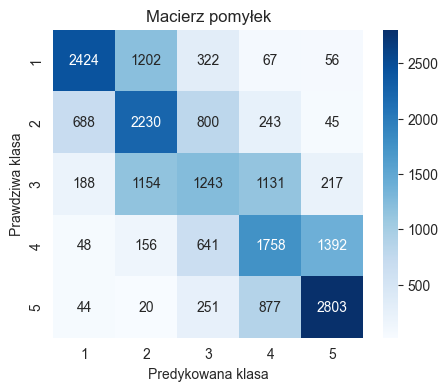

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(targets, preds)

# Create a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Macierz pomyłek')
plt.xlabel('Predykowana klasa')
plt.ylabel('Prawdziwa klasa')
plt.show()

1.   
Napisz funkcję znajdującą i wyświetlającą $k$ elementów zbioru testowego dla których model najbardziej się myli, czyli estymuje najmniejsze prawdopodobieństwa prawdziwej klasy. Softmax jest funkcją ściśle rosnącą, więc wystarczy znaleźć elementy z najmniejszą wartością nieznormalizowanego wyjścia z sieci (logita) dla prawdziwej klasy.


In [28]:
def test_k_mistakes(k):

  classifier.eval()

  true_logits = torch.empty(0).to(device)

  for X_batch, target in tqdm(dataloaders['test']):
      X_batch, target = X_batch.to(device), target.to(device)

      with torch.inference_mode():
          logits = classifier(X_batch)
          true_logits = torch.cat([true_logits, logits[torch.arange(len(logits)), target]], dim=0)

  true_logits = true_logits.cpu()
  k_min = torch.topk(true_logits, k=min(k, true_logits.shape[0]), dim=0, largest=False)

  for ndx in k_min.indices.tolist():
    x, target = datasets['test'][ndx]
    print()
    print(f"Opinia: {test_dataset[ndx]['text']}")
    print(f"Prawdziwa klasa: {target}")

test_k_mistakes(5)


100%|██████████| 79/79 [00:00<00:00, 144.44it/s]


Opinia: Look, we all know Cox sucks. In fact they are a terrible business and their practices are laughable. However they are a necessary evil if you want Internet that isn't garbage that can handle streaming/gaming. The way they handle issues over the phone is worse than Comcast, and for all my east coast brothers/sisters you know what a serious accusation that is. It all started with shitty TV Service. My household went through 4 dvr boxes. 4. That all broke. All of them. 100's of hours of TV. Lost. Every. Single. Time. Their solution? Downgrade from contour. That's their genius solution. So my solution? Upgrade to Dish for TV. PROBLEM SOLVED. However they charged us $200 to disconnect claiming we were on a contract. Nope, disputed that. However to dispute it you have to literally mail a letter to corporate. In the mean time, they cut off my Internet service for pay bills AND THEN DOUBLE CHARGED ME FOR THE INTERNET. WHAT? EXCUSE ME? How does that even make sense? So, an angry phone 

2.   Zbadaj wpływ wybranych parametrów funkcji ekstrakcji cech z tekstu `TfidfVectorizer` na skuteczność wytrenowanego modelu. Uruchom kilka eksperymentów z różnymi wartościami parametrów i porównaj dokładność wytrenowanego modelu na zbiorze walidacyjnym.


In [29]:
def test_TfidfVectorizer(vocab_size=10000, lowercase=True, analyzer='word', ngram_range=(1, 1), stop_words="english"):
  train_tfidf_features, val_tfidf_features, test_tfidf_features, feature_names = get_tfidf_features(vocab_size)

  datasets = {
      'train': make_dataset(train_tfidf_features, train_dataset['label']),
      'val': make_dataset(val_tfidf_features, val_dataset['label']),
      'test': make_dataset(test_tfidf_features, test_dataset['label'])
  }

  batch_size = 256
  dataloaders = {split: DataLoader(datasets[split], batch_size=batch_size, shuffle=split=='train', num_workers=0) for split in datasets}

  classifier = ReviewScoreClassifier(vocab_size, n_classes=5)
  classifier.to(device)

  num_epochs = 8
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

  train(classifier, dataloaders, criterion, optimizer, lr_scheduler, num_epochs, verbose=0)

  preds_l = []
  targets_l = []

  classifier.eval()

  for X_batch, target in dataloaders['test']:
      X_batch, target = X_batch.to(device), target.to(device)

      with torch.inference_mode():
          logits = classifier(X_batch)
          _, preds = torch.max(logits, dim=-1)
          preds_l.extend(preds.cpu().numpy())
          targets_l.extend(target.cpu().numpy())

  preds = np.array(preds_l)
  targets = np.array(targets_l)

  from sklearn.metrics import classification_report

  labels = ['1', '2', '3', '4', '5']

  report = classification_report(targets, preds, target_names = labels, output_dict=True)
  return report['accuracy']


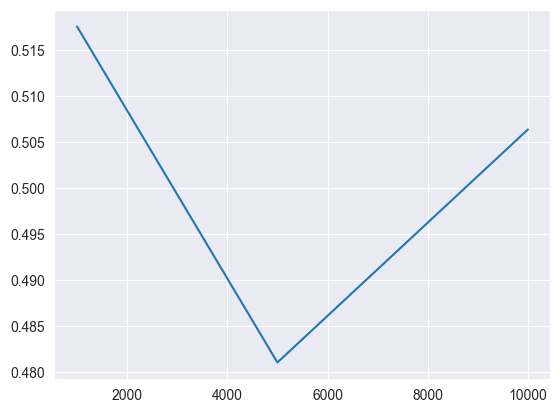

In [31]:
vocab_size_tests = [1000, 5000, 10000]
results = []
for vocab_size in vocab_size_tests:
  results.append(test_TfidfVectorizer(vocab_size=vocab_size))
plt.plot(vocab_size_tests, results)
plt.show()

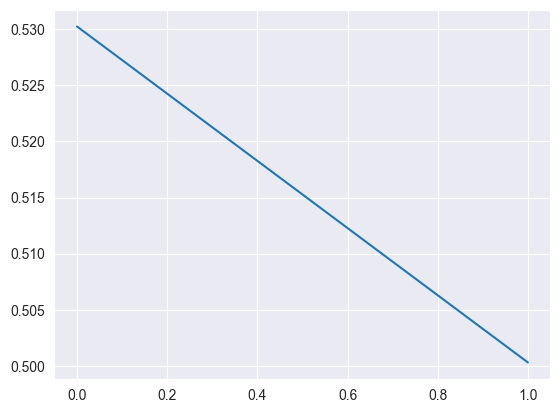

In [32]:
lowercase_tests = [True, False]
results = []
for lowercase in lowercase_tests:
  results.append(test_TfidfVectorizer(lowercase=lowercase, vocab_size=5000))
plt.plot(lowercase_tests, results)
plt.show()

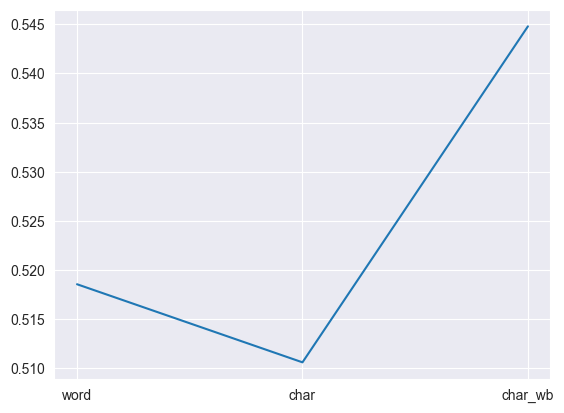

In [33]:
analyzer_tests = ['word', 'char', 'char_wb']
results = []
for analyzer in analyzer_tests:
  results.append(test_TfidfVectorizer(analyzer=analyzer))
plt.plot(analyzer_tests, results)
plt.show()

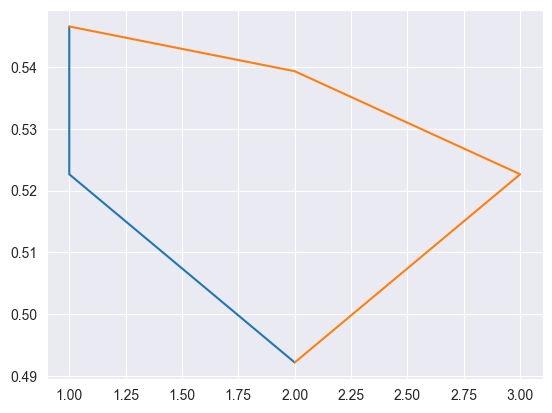

In [34]:
ngram_range_tests = [(1,1), (1,2), (1,3), (2,2)]
labels = ['(1, 1)', '(1, 2)', '(1,3)', '(2, 2)']
results = []
for ngram_range in ngram_range_tests:
  results.append(test_TfidfVectorizer(ngram_range=ngram_range))
plt.plot(labels, results)
plt.show()

TypeError: 'value' must be an instance of str or bytes, not a None

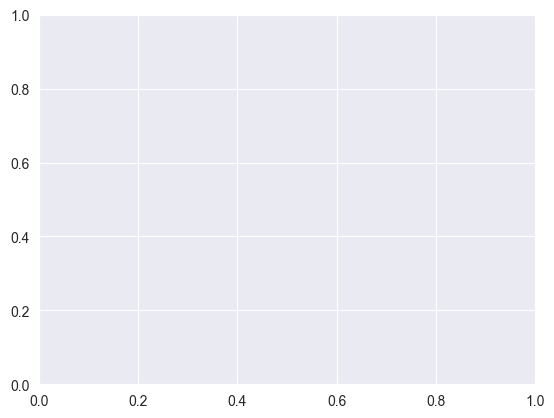

In [35]:
stop_words_tests=['english', None]
labels = ['english', 'None']
results = []
for stop_words in stop_words_tests:
  results.append(test_TfidfVectorizer(stop_words=stop_words))
plt.plot(labels, results)
plt.show()

3.   Zbadaj wpływ wybranych hiperparametrów modelu (np. liczba warstw liniowych modelu, rozmiary warstw) i procesu uczenia (np. początkowa wartość stopy uczenia, liczba epok, typ i parametry planisty stopy uczenia, typ i parametry optymalizatora) na skuteczność wytrenowanego modelu. Uruchom kilka eksperymentów z różnymi wartościami hiperparametrów i porównaj dokładność wytrenowanego modelu na zbiorze walidacyjnym. Następnie wykonaj finalną ewaluację najlepszego modelu na zbiorze testowym.